In [ ]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments

In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [2]:
processor_id="microsoft/layoutlmv2-base-uncased"
dataset_id ="nielsr/funsd"

In [3]:
from datasets import load_dataset

dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Train dataset size: 149
Test dataset size: 50


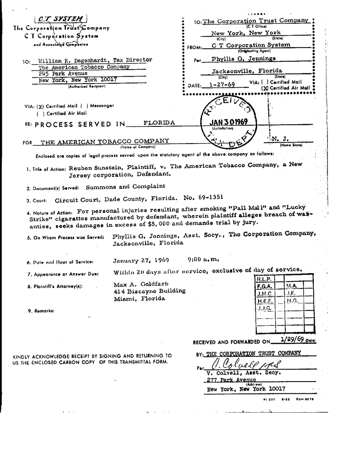

In [4]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open(dataset['train'][34]['image_path'])
image = image.convert("RGB")
image.resize((350,450))


In [5]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")

id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


In [6]:
from transformers import LayoutLMv2Processor

# use LayoutLMv2 processor without ocr since the dataset already includes the ocr text
processor = LayoutLMv2Processor.from_pretrained(processor_id, apply_ocr=False)


/Users/zwang/myenv/lib/python3.9/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


preprocessor_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

In [7]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D


# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(Value(dtype="int64")),
        "token_type_ids": Sequence(Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)

# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        Image.open(sample["image_path"]).convert("RGB"),
        sample["words"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    del encoding["image"]
    return encoding


# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image_path", "words", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")

print(proc_dataset["train"].features.keys())


Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels'])


In [8]:
from transformers import LayoutLMForTokenClassification

# huggingface hub model id
model_id = "microsoft/layoutlm-base-uncased"

# load model with correct number of labels and mapping
model = LayoutLMForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)


/Users/zwang/myenv/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/zwang/myenv/lib/python3.9/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlm-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
import evaluate
import numpy as np

# load seqeval metric
metric = evaluate.load("seqeval")

# labels of the model
ner_labels = list(model.config.id2label.values())


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [11]:
import torch

device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
model.to(device)
device

device(type='mps')

In [15]:
# hugging face parameter
repository_id = "layoutlm-funsd"

# Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    num_train_epochs=15,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=False,
    learning_rate=2e-5,
    # # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="epoch",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # # push to hub parameters
    # report_to="tensorboard",
    # push_to_hub=True,
    # hub_strategy="every_save",
    # hub_model_id=repository_id,
    # hub_token=HfFolder.get_token(),
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)


In [16]:
# Start training
trainer.train()

  0%|          | 0/285 [00:00<?, ?it/s]

{'loss': 0.0, 'learning_rate': 1.866666666666667e-05, 'epoch': 1.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.4577, 'eval_samples_per_second': 9.161, 'eval_steps_per_second': 1.283, 'epoch': 1.0}
{'loss': 0.0, 'learning_rate': 1.7333333333333336e-05, 'epoch': 2.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.2728, 'eval_samples_per_second': 9.483, 'eval_steps_per_second': 1.328, 'epoch': 2.0}
{'loss': 0.0, 'learning_rate': 1.6000000000000003e-05, 'epoch': 3.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.2873, 'eval_samples_per_second': 9.457, 'eval_steps_per_second': 1.324, 'epoch': 3.0}
{'loss': 0.0, 'learning_rate': 1.4666666666666666e-05, 'epoch': 4.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.4624, 'eval_samples_per_second': 9.153, 'eval_steps_per_second': 1.281, 'epoch': 4.0}
{'loss': 0.0, 'learning_rate': 1.3333333333333333e-05, 'epoch': 5.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.1382, 'eval_samples_per_second': 9.731, 'eval_steps_per_second': 1.362, 'epoch': 5.0}
{'loss': 0.0, 'learning_rate': 1.2e-05, 'epoch': 6.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.2311, 'eval_samples_per_second': 9.558, 'eval_steps_per_second': 1.338, 'epoch': 6.0}
{'loss': 0.0, 'learning_rate': 1.0666666666666667e-05, 'epoch': 7.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.126, 'eval_samples_per_second': 9.754, 'eval_steps_per_second': 1.366, 'epoch': 7.0}
{'loss': 0.0, 'learning_rate': 9.333333333333334e-06, 'epoch': 8.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.2317, 'eval_samples_per_second': 9.557, 'eval_steps_per_second': 1.338, 'epoch': 8.0}
{'loss': 0.0, 'learning_rate': 8.000000000000001e-06, 'epoch': 9.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.5454, 'eval_samples_per_second': 9.016, 'eval_steps_per_second': 1.262, 'epoch': 9.0}
{'loss': 0.0, 'learning_rate': 6.666666666666667e-06, 'epoch': 10.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.2854, 'eval_samples_per_second': 9.46, 'eval_steps_per_second': 1.324, 'epoch': 10.0}
{'loss': 0.0, 'learning_rate': 5.333333333333334e-06, 'epoch': 11.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 4.9965, 'eval_samples_per_second': 10.007, 'eval_steps_per_second': 1.401, 'epoch': 11.0}
{'loss': 0.0, 'learning_rate': 4.000000000000001e-06, 'epoch': 12.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.4655, 'eval_samples_per_second': 9.148, 'eval_steps_per_second': 1.281, 'epoch': 12.0}
{'loss': 0.0, 'learning_rate': 2.666666666666667e-06, 'epoch': 13.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.1666, 'eval_samples_per_second': 9.677, 'eval_steps_per_second': 1.355, 'epoch': 13.0}
{'loss': 0.0, 'learning_rate': 1.3333333333333334e-06, 'epoch': 14.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.1953, 'eval_samples_per_second': 9.624, 'eval_steps_per_second': 1.347, 'epoch': 14.0}
{'loss': 0.0, 'learning_rate': 0.0, 'epoch': 15.0}


  0%|          | 0/7 [00:00<?, ?it/s]

/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/zwang/myenv/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}" of type <class 'dict'> for key "eval/HEADE

{'eval_loss': nan, 'eval_ANSWER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 809}, 'eval_HEADER': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 119}, 'eval_QUESTION': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1065}, 'eval_overall_precision': 0.0, 'eval_overall_recall': 0.0, 'eval_overall_f1': 0.0, 'eval_overall_accuracy': 0.27504085921083354, 'eval_runtime': 5.1257, 'eval_samples_per_second': 9.755, 'eval_steps_per_second': 1.366, 'epoch': 15.0}
{'train_runtime': 1218.7615, 'train_samples_per_second': 1.834, 'train_steps_per_second': 0.234, 'train_loss': 0.0, 'epoch': 15.0}


TrainOutput(global_step=285, training_loss=0.0, metrics={'train_runtime': 1218.7615, 'train_samples_per_second': 1.834, 'train_steps_per_second': 0.234, 'train_loss': 0.0, 'epoch': 15.0})

In [17]:
# change apply_ocr to True to use the ocr text for inference
processor.feature_extractor.apply_ocr = True

# Save processor and create model card
processor.save_pretrained(repository_id)
trainer.create_model_card()
trainer.push_to_hub()

/Users/zwang/myenv/lib/python3.9/site-packages/transformers/models/layoutlmv2/processing_layoutlmv2.py:196: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


events.out.tfevents.1701215550.daruiruidekuailetong.local.70323.0:   0%|          | 0.00/4.46k [00:00<?, ?B/s]

events.out.tfevents.1701215876.daruiruidekuailetong.local.70323.1:   0%|          | 0.00/14.6k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.54k [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

'https://huggingface.co/KRayRay/layoutlm-funsd/tree/main/'

config.json:   0%|          | 0.00/1.04k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/451M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/199 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


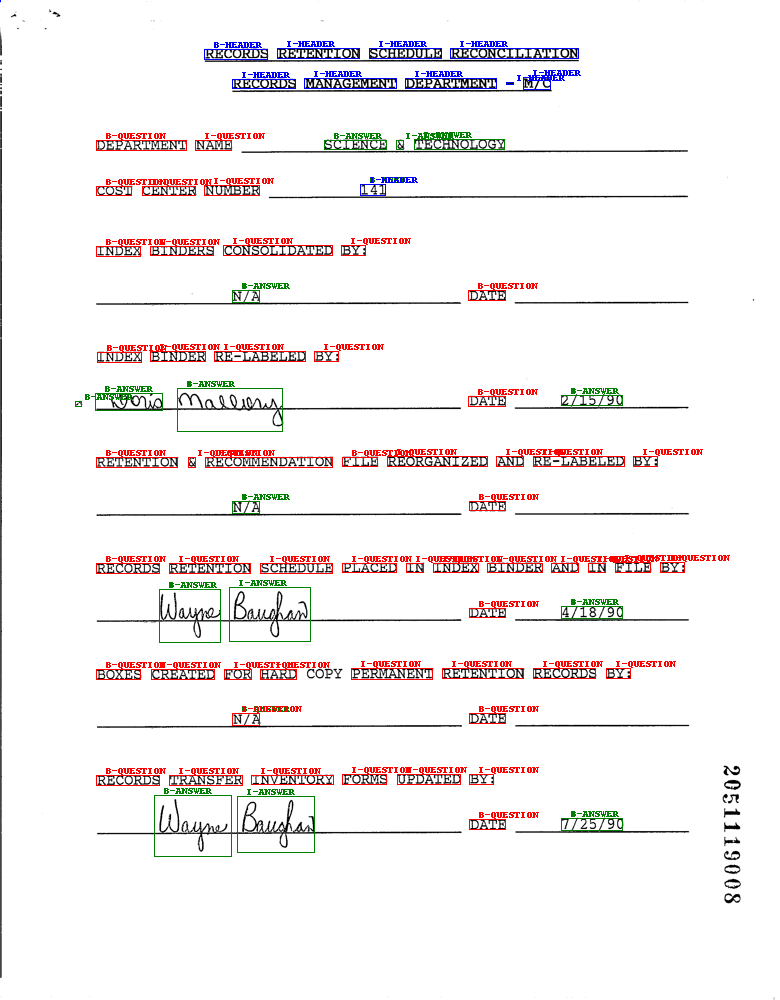

In [18]:
from transformers import LayoutLMForTokenClassification, LayoutLMv2Processor
from PIL import Image, ImageDraw, ImageFont
import torch

# load model and processor from huggingface hub
model = LayoutLMForTokenClassification.from_pretrained("philschmid/layoutlm-funsd")
processor = LayoutLMv2Processor.from_pretrained("philschmid/layoutlm-funsd")


# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]


label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]

    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image


# run inference
def run_inference(path, model=model, processor=processor, output_image=True):
    # create model input
    image = Image.open(path).convert("RGB")
    encoding = processor(image, return_tensors="pt")
    del encoding["image"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels


run_inference(dataset["test"][34]["image_path"])
